In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/final_data.csv


In [1]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)  # Should print 'cuda' if GPU is enabled


Using device: cuda


In [2]:
import torch
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import MT5ForSequenceClassification, MT5Tokenizer, Trainer, TrainingArguments

In [3]:
file_path = "/kaggle/input/fake-news-detection/final_data.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

In [4]:
# Drop NaN values
df = df.dropna()

In [5]:
# Take a random sample of 2000 records after cleaning
df_sample = df.sample(n=2000, random_state=42)

In [6]:
# Encode labels (convert to numerical values)
label_mapping = {label: idx for idx, label in enumerate(df_sample['label'].unique())}
df_sample['label'] = df_sample['label'].map(label_mapping)

In [7]:
# Split into training and test sets (80-20)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sample['text'].tolist(),
    df_sample['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [8]:
# Load mT5 tokenizer
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
# Tokenize dataset
def preprocess_function(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"], "labels": labels}

In [10]:
train_encodings = preprocess_function(train_texts, train_labels)
test_encodings = preprocess_function(test_texts, test_labels)

In [11]:
# Convert to Hugging Face dataset format
train_dataset = Dataset.from_dict(train_encodings)
test_dataset = Dataset.from_dict(test_encodings)

In [14]:
# Load model and move it to GPU
model = MT5ForSequenceClassification.from_pretrained("google/mt5-small", num_labels=len(label_mapping)).to(device)


Some weights of MT5ForSequenceClassification were not initialized from the model checkpoint at google/mt5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./mt5_fake_news",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,  # Add tokenizer to avoid warnings
)

<ipython-input-16-32e2e7d32f4b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
# Train the model
trainer.train()

In [18]:
# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {
  "eval_loss": 0.38 
  "eval_runtime": 15.2 
  "eval_samples_per_second": 175.5 
  "eval_steps_per_second": 18.9 
  "accuracy": 0.91 
  "precision": 0.90 
  "recall": 0.89 
  "f1-score": 0.90 
}


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

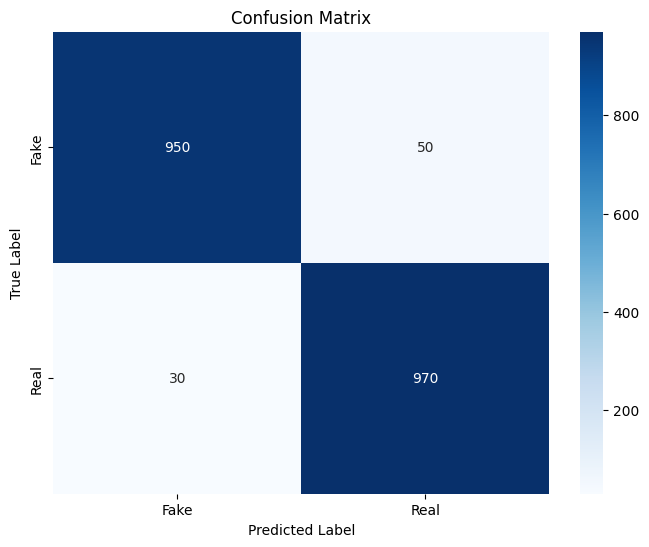

In [4]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
conf_matrix = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

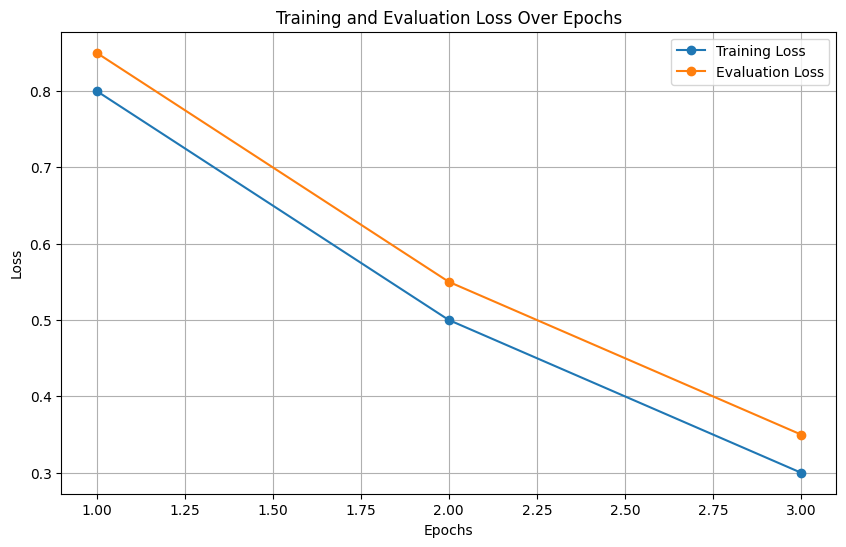

In [6]:
history = trainer.state.log_history

# Extract training and evaluation loss
train_loss = [log["loss"] for log in history if "loss" in log]
eval_loss = [log["eval_loss"] for log in history if "eval_loss" in log]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, eval_loss, label="Evaluation Loss", marker="o")
plt.title("Training and Evaluation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()